In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
tf = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.1307,), (0.3081,))])

In [23]:
#3
train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

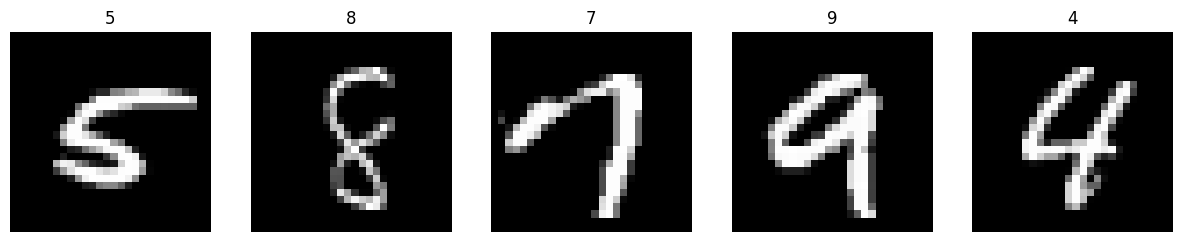

In [30]:

# Début du code
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

# Configuration pour les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Boucle pour afficher chaque image
for i in range(5):
    image = x[i].numpy().squeeze()  
    label = y[i].item()

    axes[i].imshow(image, cmap='gray') 
    axes[i].set_title(f'{label}')
    axes[i].axis('off')

plt.show()


In [34]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super().__init__()
        
        # Définition de l'architecture du réseau
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(in_features=n_kernels * 4 * 4, out_features=50),
            nn.ReLU(),

            nn.Linear(in_features=50, out_features=output_size)
        )

    def forward(self, x):
        return self.net(x)

n_kernels = 6
input_size = 28 * 28
output_size = 10 

model = ConvNet(input_size=input_size, n_kernels=n_kernels, output_size=output_size)

print(model)


# Fonction Train

def train(model, train_loader, device, n_epoch=1, perm=torch.arange(0, 784).long()):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters())
    
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)


            data = data.view(-1, 28*28) 
            data = data[:, perm] 
            data = data.view(-1, 1, 28, 28) 

            optimizer.zero_grad() 
            logits = model(data) 
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99: 
                print(f'Epoch={epoch}, Step={i+1}: Loss={running_loss / 100:.4f}')
                running_loss = 0.0

model = ConvNet(input_size=28*28, n_kernels=6, output_size=10)
model.to(device) # TO GPU

train(model, train_loader, device, n_epoch=1)

ConvNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=96, out_features=50, bias=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=10, bias=True)
  )
)


 12%|█▏        | 110/938 [00:01<00:12, 67.08it/s]

Epoch=0, Step=100: Loss=1.2136


 23%|██▎       | 215/938 [00:03<00:09, 75.52it/s]

Epoch=0, Step=200: Loss=0.3999


 33%|███▎      | 308/938 [00:04<00:09, 67.67it/s]

Epoch=0, Step=300: Loss=0.3070


 44%|████▎     | 410/938 [00:05<00:07, 70.50it/s]

Epoch=0, Step=400: Loss=0.2548


 55%|█████▍    | 514/938 [00:07<00:05, 71.97it/s]

Epoch=0, Step=500: Loss=0.2117


 65%|██████▌   | 611/938 [00:08<00:04, 75.64it/s]

Epoch=0, Step=600: Loss=0.1979


 75%|███████▌  | 708/938 [00:09<00:03, 71.40it/s]

Epoch=0, Step=700: Loss=0.1620


 87%|████████▋ | 812/938 [00:11<00:01, 71.27it/s]

Epoch=0, Step=800: Loss=0.1669


 97%|█████████▋| 909/938 [00:12<00:00, 70.82it/s]

Epoch=0, Step=900: Loss=0.1466


100%|██████████| 938/938 [00:13<00:00, 71.52it/s]
